## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from collections import defaultdict

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error as mse, make_scorer

from lightgbm import LGBMRegressor

from joblib import dump, load

import matplotlib.pyplot as plt

PATH = '/datasets/'
SEED = 21

In [2]:
data = pd.read_csv(os.path.join(PATH, 'taxi.csv'),
                   parse_dates=['datetime'],
                   index_col='datetime')
data.info()
data.head(3)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28


In [3]:
if not data.index.is_monotonic:
    data = data.sort_index()
    
data = data.resample('1H').sum()

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

<font color="blue">Отлично

# 2. Анализ

Построим общий и частные графики

Выполним декомпозицию и посмотим на тренды и сезонность

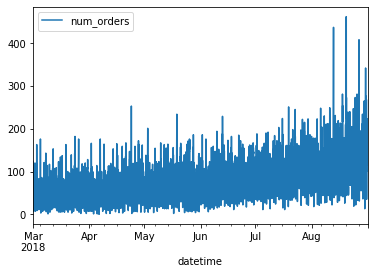

In [6]:
data.plot()

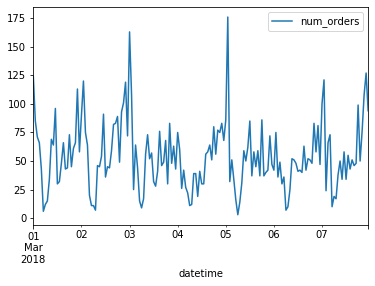

In [7]:
data.head(24*7).plot()

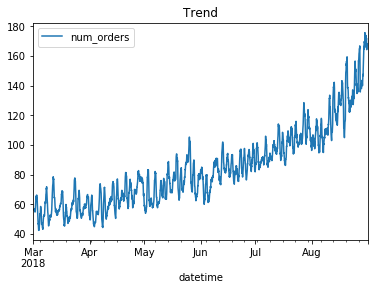

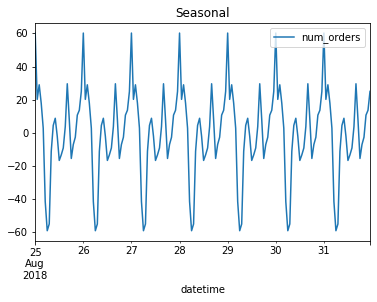

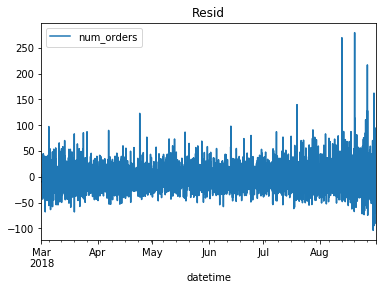

In [8]:
decomposed_data = seasonal_decompose(data)
decomposed_data.trend.plot(title='Trend')
decomposed_data.seasonal.tail(24*7).plot(title='Seasonal')
decomposed_data.resid.plot(title='Resid')

Как мы видим, есть дневная сезонность, восходящий тренд

# 3. Обучение

1. Реализуем метрику
1. Реализуем добавление признаков через класс Sklearn TransformerMixin
1. Разобьем данные на трейн и тест
1. Проверим несколько моделей поиском по сетке: Ridge, Lasso, RandomForest
1. Выберем лучшую и проверим на тесте

In [9]:
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

rmse = make_scorer(root_mean_squared_error, greater_is_better=False)

In [10]:
class TimeFeaturesMaker(BaseEstimator, TransformerMixin):
    '''
    '''
    def __init__(self,
                 max_lag,
                 rolling_mean_size,
                 target,
                 year=True,
                 month=True,
                 day=True,
                 dayofweek=True,
                 hour=True,
                 fillna=True):
        '''
        '''
        self.max_lag = max_lag
        self.rolling_mean_size = rolling_mean_size
        self.year = year
        self.month = month
        self.day = day
        self.dayofweek = dayofweek
        self.hour=hour
        self.fillna = fillna
        self.target =target
        
        self.lag_ = defaultdict()
        
    
    def _reset(self):        
        if hasattr(self, 'X_'):               
            del self.X_
            del self.y_
        
        
    def fit(self, X, y=None):
        """Save datetime index and target
        
        Parameters
        ----------
        X : {pandas.DataFrame}, shape [n_samples, n_features]
            The data used to add time features, index must be datetime
            Must contains target column
        """
        self._reset()           
        
        
        self.X_ = X.drop(columns=self.target)
        self.y_ = X[self.target]
        
        return self
            
    
    
    def transform(self, X):
        """Add time seatures
        Parameters
        ----------
        X : {pandas.DataFrame}, shape [n_samples, n_features]
            The data used to add time features, index must be datetime
            Must contains target column
            Target column will dropped after adding feat
        
        """

        temp = X.copy()
        
        for l in range(self.max_lag):
            temp['lag_'+str(l)] = temp[self.target].shift(l+1)
            
        temp['rolling_mean'] = temp[self.target].shift().rolling(self.rolling_mean_size).mean()
        
        if self.year:
            temp['year'] = X.index.year
        if self.month:
            temp['month'] = X.index.month           
        if self.day:
            temp['day'] = X.index.day
        if self.dayofweek:
            temp['dayofweek'] = X.index.dayofweek
        if self.hour:
            temp['hour'] = X.index.hour
            temp['sin_hour'] = np.sin(2*np.pi*X.index.hour/24)
            temp['cos_hour'] = np.cos(2*np.pi*X.index.hour/24)
        #fill na from previous values
        if self.fillna:
            for l in  range(self.max_lag+1):
                temp.iloc[:l+1, l] = self.y_[-l-1:].values.T
                
            temp.loc[:self.rolling_mean_size, 'rolling_mean'] = \
            self.y_[-self.rolling_mean_size:].values.T
        
        #drop target
        temp = temp.drop(columns=self.target)

        return temp

Проверим что работает

In [11]:
maker = TimeFeaturesMaker(4, 3, 'num_orders', year=False)

X = data
y = data['num_orders']

maker.fit_transform(X).head(2)

,lag_0,lag_1,lag_2,lag_3,rolling_mean,month,day,dayofweek,hour,sin_hour,cos_hour
datetime,,,,,,,,,,,
2018-03-01 00:00:00,223.0,159.0,154.0,136.0,159.0,3,1,3,0,0.000000,1.000000
2018-03-01 01:00:00,205.0,223.0,159.0,154.0,223.0,3,1,3,1,0.258819,0.965926


Разделим на трейн и тест

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

Подготовим параметры для поиска по сетки

In [13]:
pipe = Pipeline([
    ('maker', TimeFeaturesMaker(24, 5, 'num_orders', year=False, fillna=True)),
    ('model', RandomForestRegressor(n_estimators=100, random_state=SEED))
])



cat_col = ['month', 'day', 'dayofweek', 'hour']
cat_col_num = []

#for col in cat_col:
#    cat_col_num.append(data.columns.to_list().index(col))

params = [
    {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [RandomForestRegressor(n_estimators=100, random_state=SEED)],
        'model__max_features': np.linspace(0.1, 1, 5)
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [Lasso(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 5)
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [Ridge(random_state=SEED)],
        'model__alpha': np.logspace(-3, 1, 5)
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LGBMRegressor(boosting_type='gbdt', verbose=0, random_state=SEED, n_estimators=100)],
        #'model__categorical_feature': ['auto', cat_col_num],
        'model__num_leaves': [20, 31, 40],
        'model__max_depth': [-1, 10, 20],
        'model__learning_rate': [0.08, 0.1, 0.12]
    }, {
        'maker__max_lag': [24, 48, 168],
        'maker__rolling_mean_size': [5, 10, 20],
        'model': [LinearRegression()],
    }
]

Готовим поиск по сетке

In [14]:
cv = TimeSeriesSplit(n_splits=2)

grid = GridSearchCV(pipe, param_grid=params, scoring=rmse, cv=cv, verbose=True)

In [15]:
%%time
grid.fit(X_train, y_train)
file_name = 'my_grid'
dump(grid, file_name);

Fitting 2 folds for each of 387 candidates, totalling 774 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 774 out of 774 | elapsed: 38.4min finished


CPU times: user 36min 20s, sys: 1min 42s, total: 38min 3s
Wall time: 38min 23s


['my_grid']

In [16]:
grid = load(file_name, mmap_mode='r')

In [17]:
grid.best_score_, grid.best_params_

(-23.681825126321574,
 {'maker__max_lag': 168,
  'maker__rolling_mean_size': 10,
  'model': Lasso(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=1000,
        normalize=False, positive=False, precompute=False, random_state=21,
        selection='cyclic', tol=0.0001, warm_start=False),
  'model__alpha': 10.0})

Вытащим из результатов поиска по сетке лучшие модели и сведем их в одну таблицу

In [18]:
grid_results = pd.DataFrame(grid.cv_results_)
models = ['Lasso', 'Ridge', 'RandomForestRegressor', 'LGBMRegressor', 'LinearRegression']
cols = ['mean_fit_time', 'mean_score_time', 'mean_test_score']
res = pd.DataFrame(columns=cols)

for model in models:
    model_idx = grid_results['param_model'].astype('str').str.contains(model)
    best_fit = grid_results[model_idx].sort_values(by='rank_test_score').head(1)[cols]
    res = res.append(best_fit)
    res.loc[best_fit.index, 'model'] = model
    
res.sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,model
84,0.714091,0.633363,-23.681825,Lasso
124,0.505360,0.494868,-24.367379,Ridge
44,17.025148,0.343610,-24.369902,RandomForestRegressor
384,0.641226,0.437923,-24.496508,LinearRegression
300,3.036761,0.426234,-24.516991,LGBMRegressor


Как мы видим, самое оптимальное качество и время показывает Lasso регрессия

# 4. Тестирование

Выберем лучшу модель и проверим метрику на тесте

In [19]:
model = grid.best_estimator_
    
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
root_mean_squared_error(y_test, y_pred)

38.56125164092052

Дополнительно посмотрим график реальных значений и предсказанных

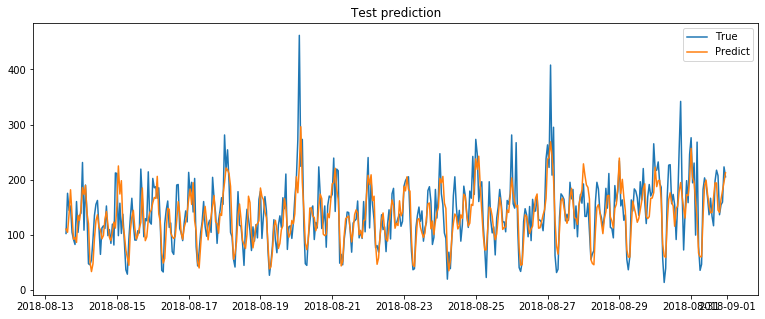

In [20]:
plt.figure(figsize=(13, 5))

plt.plot(y_test, label='True')
plt.plot(y_test.index, y_pred, label='Predict')

plt.title('Test prediction')
plt.legend()
plt.show()

Даже не знаю какие выводы написать, попробую как-то так:

Для прогнозирования временного ряда были выполнены следующие шаги:
1. Данные ресемплированы по 1 часу
1. Проведена генерация признаков
1. Поиском по сетке искалась лучшая модель с лучшими гиперпараметрами из: 'Lasso', 'Ridge', 'RandomForestRegressor', 'LGBMRegressor', 'LinearRegression'
1. Данные всех моделей сведены в 1 таблицу
1. В качестве лучшей выбрана Lasso регрессия
1. Достигнутое значение метрики RMSE на тестовой выборке: ~38

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48